In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.4.0


# FMCW Radar Interference

## Introduction

The interference in automotive radar systems refers to the presence of extraneous signals or electromagnetic disturbances that can disrupt the accurate operation of the radar sensors. These disruptions can arise from various sources such as other radar systems, electronic devices, or natural environmental factors. Interference can lead to false readings, degraded performance, and potentially hazardous situations if not effectively managed. Automotive radar interference mitigation strategies involve techniques like frequency selection, signal processing algorithms, and advanced sensor design to ensure reliable and safe radar functionality in complex and dynamic driving environments.

Through the utilization of [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/), individuals gain the capability to proficiently configure diverse waveform profiles tailored to specific radar systems. This empowers them to meticulously explore the intricate interactions between these waveforms, a pivotal process that significantly contributes to advancing interference mitigation algorithms.

In this illustrative example, we will showcase the process of configuring an interference radar within the simulation environment. Subsequently, we will delve into the exploration of its consequential impact on the baseband samples of a victim radar.

## Setup Interference Radar

The interference radar has up chirps, with incremental frequency offset for each chirp. The chirp repetition time is 11e-6 s.
The interfernce radar is located at (30, 0, 0) m and facing towards `-x` direction.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver


f_offset_int = np.arange(0, 8) * 70e6
int_tx = Transmitter(
    f=[60.4e9, 60.6e9],
    t=[0, 8e-6],
    tx_power=15,
    prp=11e-6,
    pulses=8,
    f_offset=f_offset_int,
    channels=[
        dict(location=(0, 0.1, 0), pulse_phs=np.array([0, 0, 180, 0, 0, 0, 0, 0]))
    ],
)

int_rx = Receiver(
    fs=20e6,
    noise_figure=8,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[dict(location=(0, 0.1, 0))],
)

int_radar = Radar(
    transmitter=int_tx, receiver=int_rx, location=(30, 0, 0), rotation=(180, 0, 0)
)

## Setup Victim Radar

The victim radar has down chirps, with incremental frequency offset for each chirp. The chirp repetition time is 40e-6 s.
The victim radar is located at (0, 0, 0) m and facing towards `+x` direction.

Add the interference radar into the victim radar by setting `interf`.


In [3]:
f_offset_vit = np.arange(0, 4) * 90e6
tx = Transmitter(
    f=[60.6e9, 60.4e9],
    t=[0, 16e-6],
    tx_power=25,
    prp=20e-6,
    pulses=4,
    f_offset=f_offset_vit,
    channels=[dict(location=(0, 0, 0), pulse_phs=np.array([180, 0, 0, 0]))],
)

rx = Receiver(
    fs=40e6,
    noise_figure=2,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=60,
    channels=[dict(location=(0, 0, 0))],
)

radar = Radar(transmitter=tx, receiver=rx)

## Target

We add 2 targets here with different ranges and speeds.


In [4]:
target_1 = dict(location=(30, 0, 0), speed=(0, 0, 0), rcs=10, phase=0)
target_2 = dict(location=(20, 1, 0), speed=(-10, 0, 0), rcs=10, phase=0)

targets = [target_1, target_2]

## Simulation

Use the `simulator.simc` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`

For convenience, the baseband data and the interference data are separated. To obtain the interferenced baseband data, simply add them together.


In [5]:
from radarsimpy.simulator import sim_radar

bb_data = sim_radar(radar, targets, interf=int_radar)
timestamp = bb_data["timestamp"]
baseband = bb_data["baseband"]  # baseband data without interference
interf = bb_data["interference"]  # interference data

interf_bb = baseband + interf  # baseband data with interference

_Plot the baseband samples_


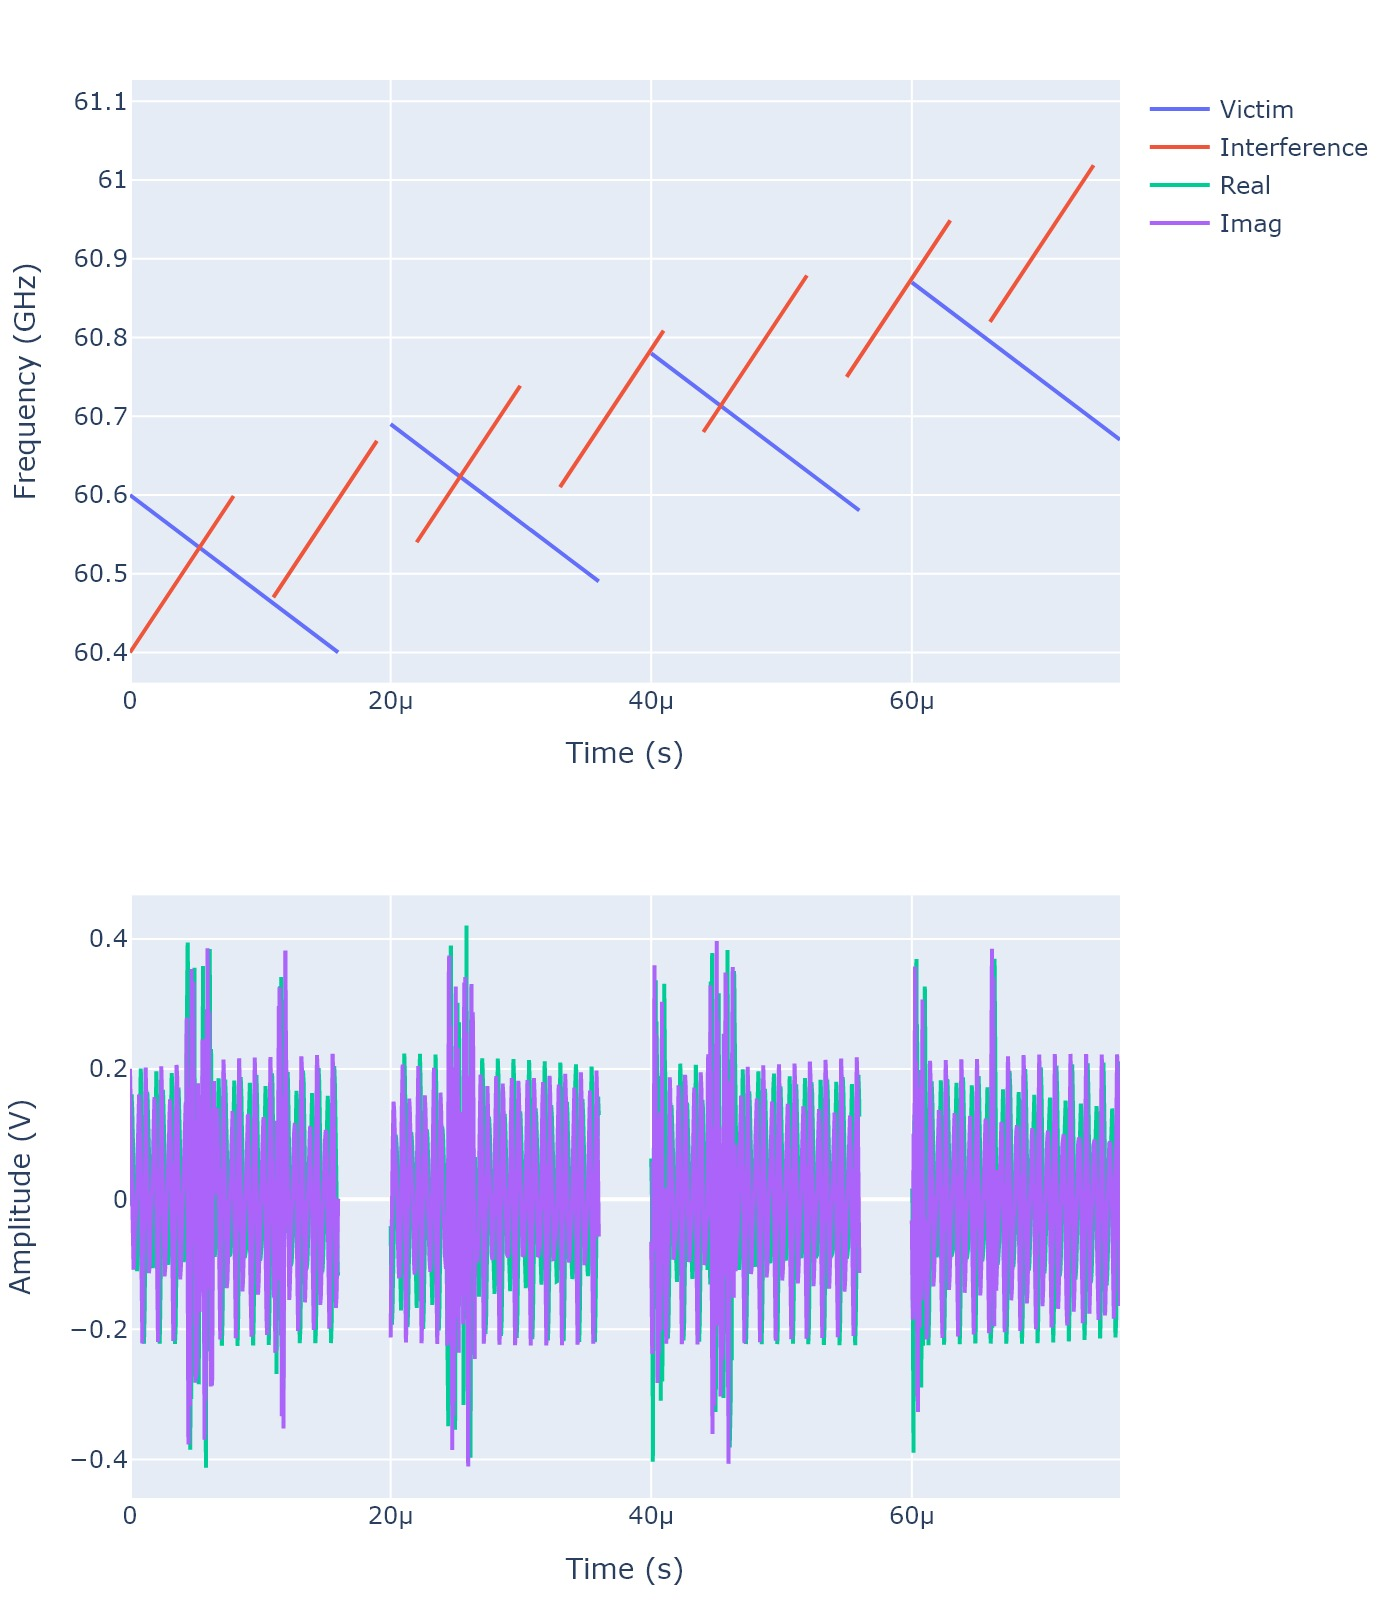

In [6]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from IPython.display import Image


fig = go.Figure()
fig = make_subplots(rows=2, cols=1)

for idx in range(0, radar.radar_prop["transmitter"].waveform_prop["pulses"]):
    fig.add_trace(
        go.Scatter(
            x=timestamp[0, idx, :],
            y=np.linspace(
                radar.radar_prop["transmitter"].waveform_prop["f"][0],
                radar.radar_prop["transmitter"].waveform_prop["f"][1],
                radar.sample_prop["samples_per_pulse"],
                endpoint=False,
            )
            / 1e9
            + f_offset_vit[idx] / 1e9,
            line=dict(color=px.colors.qualitative.Plotly[0]),
            name="Victim",
            showlegend=(idx == 0),
        ),
        row=1,
        col=1,
    )

for idx in range(0, int_radar.radar_prop["transmitter"].waveform_prop["pulses"]):
    fig.add_trace(
        go.Scatter(
            x=int_radar.time_prop["timestamp"][0, idx, :],
            y=np.linspace(
                int_radar.radar_prop["transmitter"].waveform_prop["f"][0],
                int_radar.radar_prop["transmitter"].waveform_prop["f"][1],
                int_radar.sample_prop["samples_per_pulse"],
                endpoint=False,
            )
            / 1e9
            + f_offset_int[idx] / 1e9,
            line=dict(color=px.colors.qualitative.Plotly[1]),
            name="Interference",
            showlegend=(idx == 0),
        ),
        row=1,
        col=1,
    )


for idx in range(0, radar.radar_prop["transmitter"].waveform_prop["pulses"]):
    fig.add_trace(
        go.Scatter(
            x=timestamp[0, idx, :],
            y=np.real(interf_bb[0, idx, :]),
            line=dict(color=px.colors.qualitative.Plotly[2]),
            name="Real",
            showlegend=(idx == 0),
        ),
        row=2,
        col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=timestamp[0, idx, :],
            y=np.imag(interf_bb[0, idx, :]),
            line=dict(color=px.colors.qualitative.Plotly[3]),
            name="Imag",
            showlegend=(idx == 0),
        ),
        row=2,
        col=1,
    )

fig.update_xaxes(title_text="Time (s)", range=[0, timestamp[0, 3, -1]], row=1, col=1)
fig.update_yaxes(title_text="Frequency (GHz)", row=1, col=1)
fig.update_xaxes(title_text="Time (s)", range=[0, timestamp[0, 3, -1]], row=2, col=1)
fig.update_yaxes(title_text="Amplitude (V)", row=2, col=1)

fig.update_layout(
    height=800,
    margin=dict(l=10, r=10, b=10, t=40),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

From the provided data, it is evident that the samples experience contamination during periods in which the chirps from the victim radar intersect with those of the interference radar.
